# Load libraries

In [1]:
# pip install tqdm networkx plotly matplotlib pandas jinja2 kaleido
# pip install --upgrade nbformat
import os
from tqdm import tqdm
from codes.bb import *
import pandas as pd
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Exploring data

In [2]:
# read nrm files
nmr_folder = 'data/nmr_spec'
df_nmr = {'fn': [], 'i': [], 'j': [], 'dij': []}
for fn in tqdm(os.listdir(nmr_folder)):
    if not fn.endswith('.nmr'):
        continue
    fn = os.path.join(nmr_folder, fn)
    with open(fn, 'r') as fd:
        for edge in fd:
            i, j, dij = edge.split()[:3]
            # parse the edge
            i, j, dij = int(i), int(j), float(dij)
            # add the edge
            df_nmr['fn'].append(fn)
            df_nmr['i'].append(i)
            df_nmr['j'].append(j)
            df_nmr['dij'].append(dij)
# convert to dataframe
df_nmr = pd.DataFrame(df_nmr)
# add columns for dmax, pdb and chain
df_nmr['DMAX'] = df_nmr['fn'].apply(lambda fn: int(fn.split('dmax_')[1].split('.')[0]))
df_nmr['PDB'] = df_nmr['fn'].apply(lambda fn: fn.split('/')[-1].split('_')[0])
df_nmr['chain'] = df_nmr['fn'].apply(lambda fn: fn.split('/')[-1].split('_')[2])

100%|██████████| 19/19 [00:00<00:00, 10848.32it/s]


In [3]:
def get_lenS(fnmr):
    flog = fnmr.replace('.nmr', '.log')
    with open(flog, 'r') as fd:
        for row in fd:
            if '> lenS' in row:
                return int(row.split()[-1])
# columns of interest
cols = ['PDB','DMAX','i','j','fn']
dfA = df_nmr[cols].groupby(['PDB','DMAX']).agg({'i':'count', 'j':'max', 'fn':'max'}).reset_index()
dfA.rename(columns={'i':'|E|', 'j':'|V|'}, inplace=True)
# dict of dataframes, one for each dmax
df_DMAX = {dmax:None for dmax in dfA['DMAX'].unique()} 
for dmax in df_DMAX:
    df_DMAX[dmax] = dfA[dfA['DMAX'] == dmax].groupby(['PDB','|V|']).max().reset_index()
    # rename columns
    df_DMAX[dmax].rename(columns={'|E|':f'|E_{dmax}|','fn':f'|S_{dmax}|'}, inplace=True)
    # parse the log file to get the length of S
    df_DMAX[dmax][f'|S_{dmax}|'] = df_DMAX[dmax][f'|S_{dmax}|'].apply(get_lenS)
    # drop redundant columns
    if dmax == min(df_DMAX):
        df_DMAX[dmax].drop(columns=['DMAX'], inplace=True)
    else:
        df_DMAX[dmax].drop(columns=['DMAX','|V|'], inplace=True)
# merge all dataframes
dfB = df_DMAX[min(df_DMAX)]
for dmax in df_DMAX:
    if dmax == min(df_DMAX):
        continue
    dfB = pd.merge(dfB, df_DMAX[dmax], on=['PDB'])
# sort by |V|
df_DMAX = dfB.sort_values(by=['|V|'])
cols = df_DMAX.columns.tolist()
# change df_MAX column order
cols = cols[:2] + sorted(cols[2:])
df_DMAX = df_DMAX[cols]
# convert to latex
tex = df_DMAX.to_latex(index=False,
                column_format='lrrc',
                header=cols, # list of column names
                escape=False,
                caption=f'Number of nodes and edges for each instance.',
                label=f'tab:instances',
                multicolumn=False,
                multicolumn_format='c')
# save tex to file
with open('latex/tables/instances.tex', 'w') as fd:
    fd.write(tex)
# display
df_DMAX

FileNotFoundError: [Errno 2] No such file or directory: 'data/nmr_spec/testA_chain_A_dmax_5.log'

In [131]:
# |s| is the number of edges covering the segment s
df = {'PDB':[], 'DMAX':[], 'sid':[], '|s|':[]}
for fn in tqdm(os.listdir(nmr_folder)):
    # skip non-dmp files
    if not fn.endswith('.dmp'):
        continue
    # get pdb and dmax
    pdb = fn.split('_')[0]
    dmax = int(fn.split('dmax_')[1].split('.')[0])
    fn = os.path.join(nmr_folder, fn)
    with open(fn, 'r') as fd:
        reading = False # flag to start reading
        for row in fd:
            if 'segments [sid i j weight EID]:' in row:
                reading = True
                continue
            if 'E [idx eid i j SID]:' in row:
                break
            if reading:
                v = [int(s) for s in row.split()]
                sid, i, j = int(v[0]), int(v[1]), int(v[2])                
                df['PDB'].append(pdb)
                df['DMAX'].append(dmax)
                df['|s|'].append(len(v)-4)
                df['sid'].append(sid)
df = pd.DataFrame(df)
dfA = df.groupby(['DMAX']).agg({'|s|':'max'}).reset_index().sort_values(by=['DMAX'])
dfA.rename(columns={'|s|':'|s|_max'}, inplace=True)
print(dfA)


100%|██████████| 147/147 [00:00<00:00, 32226.78it/s]

   DMAX  |s|_max
0     5        5


In [132]:
fig = go.Figure()
for dmax in df['DMAX'].unique():
    dfB = df[df['DMAX'] == dmax].sort_values(by=['|s|'])
    y, PDB, SID = dfB['|s|'], dfB['PDB'], dfB['sid']
    x = np.arange(1, len(y)+1) / len(y)    
    fig.add_trace(go.Scatter(x=x, y=y, name=f'dmax={dmax}'))
    # add pdb to the hover text
    fig.data[-1].text = [f'{pdb}, sid:{sid}' for pdb, sid in zip(PDB, SID)]
# Overlay both histograms
fig.update_layout(barmode='overlay')
# xlim
fig.update_xaxes(range=[0, 1.05])
# set title
fig.update_layout(title_text='CDF of number of edges per segment')
# set x-axis title
fig.update_xaxes(title_text='CDF')
# set y-axis title
fig.update_yaxes(title_text='Number of edges on a given segment', type="log")
fig.show()

# Exploring results:

## Results: data/nmr_spec

In [45]:
nmr_folder = 'data/nmr_rand'

# run read_results.py
os.system('python read_results.py -wdir ' + nmr_folder)

# read results
df = pd.read_csv(os.path.join(nmr_folder, 'results.csv'))
print('tmax (secs) =', df['tmax'].unique())
print('')

# add columns
df['PDB'] = df.apply(lambda row: row['fnmr'].split('/')[-1].split('_')[0], axis=1)

# set columns order
cols = ['PDB','|V|','|E|','|S|','costRX', 'costGD', 'costSB']
cols += sorted([c for c in df.columns if c not in cols])
df = df[cols]

# set columns names
cols = df.columns.tolist()
cols = {c:c.replace('cost', '') for c in cols}
df.rename(columns=cols, inplace=True)

# sort by |S|
df = df.sort_values(by=['|S|'])

# remove unnecessary columns
cols = ['fnmr', 'clean_log', 'verbose', 'dump', 'tmax']
cols += [c for c in df.columns if c.startswith('time')]
cols += [c for c in df.columns if c.startswith('cost')]
df.drop(columns=cols, inplace=True)

# display
caption = 'Table of costs for each instance.'
print(caption)
pd.set_option('display.float_format', lambda x: '%g' % x)
dfA = df.groupby('PDB').max().reset_index()

# remove col solver
dfA.drop(columns=['solver'], inplace=True)

# get results where the cost are different
dfA = dfA[dfA['GD'] != dfA['SB']]
dfA = dfA[dfA['GD'] != dfA['BB']]
dfA = dfA[dfA['SB'] != dfA['BB']]

# remove tests
dfA = dfA[~dfA['PDB'].isin(['test700', 'test150', 'test794'])]

# sort using lambda
dfA['ID'] = dfA['PDB'].apply(lambda x: int(x.replace('test', '')))
dfA.sort_values(by=['ID'], inplace=True)
dfA.drop(columns=['ID'], inplace=True)

# remove BF column
dfA.drop(columns=['BF'], inplace=True)

# rename PDB as ID
dfA.rename(columns={'PDB':'ID'}, inplace=True)

# convert to columns to int
cols = ['RX', 'BB', 'GD', 'SB']
for col in cols:
    dfA[col] = dfA[col].astype(int)

# ordering columns
cols = ['ID', '|V|', '|E|', '|S|', 'RX', 'BB', 'GD', 'SB']
dfA = dfA[cols]

# convert to latex
tex = dfA.to_latex(index=False,
                column_format='lcccccccc',
                header=dfA.columns, # list of column names
                escape=False,
                caption=caption,
                label=f'tab:cost_small',
                multicolumn=False,
                multicolumn_format='c')
wdir = os.path.join('latex',nmr_folder)
if not os.path.exists(wdir):
    os.mkdir(wdir)
fn = os.path.join(wdir,'costs_small.tex')
fn = os.path.abspath(fn)
print(f'Saving LaTeX table to "{fn}"')
with open(fn, 'w') as fd:
    fd.write(tex)

# display
dfA

Parameters:
   wdir = data/nmr_rand

Getting log files from wdir=data/nmr_rand
Saving results to data/nmr_rand/results.csv
tmax (secs) = [7200]

Table of costs for each instance.
Saving LaTeX table to "/home/michael/gitrepos/bb-sbbu/latex/data/nmr_rand/costs_small.tex"


,ID,|V|,|E|,|S|,RX,BB,GD,SB
3,test34,15,4,5,54,54,68,98
0,test133,15,4,7,26,36,40,54
1,test149,14,4,6,26,74,76,82
4,test347,15,4,5,44,46,48,136


In [49]:
dfB = {'Instance ID':[],'Ordering Cost':[], 'Algorithms':[]}
for _, row in dfA.iterrows():
    for col in ['BB', 'GD', 'SB', 'RX']:
        dfB['Instance ID'].append(row['ID'])
        dfB['Ordering Cost'].append(row[col])
        dfB['Algorithms'].append(col)

# show
fig = px.bar(dfB, x='Instance ID', y='Ordering Cost', color='Algorithms', title='Costs per instance', barmode='group', log_y=True, text='Ordering Cost')
# fig.update_yaxes(range=[1e-2, 1e4])
fig.update_traces(textposition='auto') # set text position
# change x-axis label
fig.update_xaxes(title_text='Instance ID')
# change legend title
fig.update_layout(legend_title_text='Algorithms')
fig.show()
# save fig to file
wdir = os.path.join('latex',nmr_folder)
if not os.path.exists(wdir):
    os.mkdir(wdir)
fn = os.path.join(wdir,'costs_small.pdf')
print(f'Saving figure to "{fn}"')
fig.write_image(fn)

raise Exception('stop')

Saving figure to "latex/data/nmr_rand/costs_small.pdf"


Exception: stop

prune edges: [(1, 7), (4, 12), (7, 15), (9, 13)]
'/home/michael/gitrepos/bb-sbbu/data/nmr_rand/test133_chain_A_dmax_5.nmr'


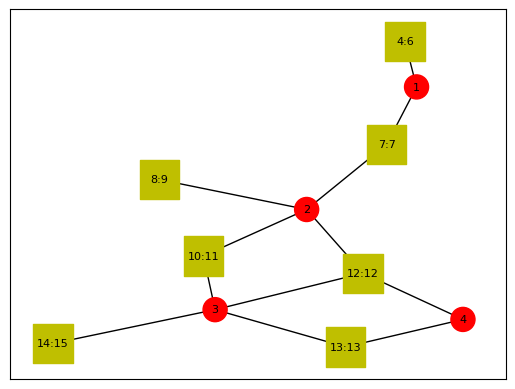

prune edges: [(1, 9), (3, 13), (4, 13), (10, 14)]
'/home/michael/gitrepos/bb-sbbu/data/nmr_rand/test149_chain_A_dmax_5.nmr'


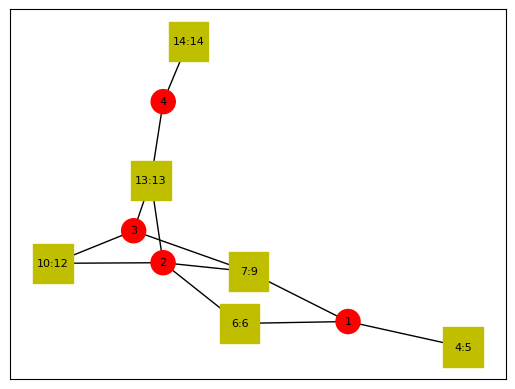

prune edges: [(2, 11), (2, 14), (7, 12), (9, 15)]
'/home/michael/gitrepos/bb-sbbu/data/nmr_rand/test347_chain_A_dmax_5.nmr'


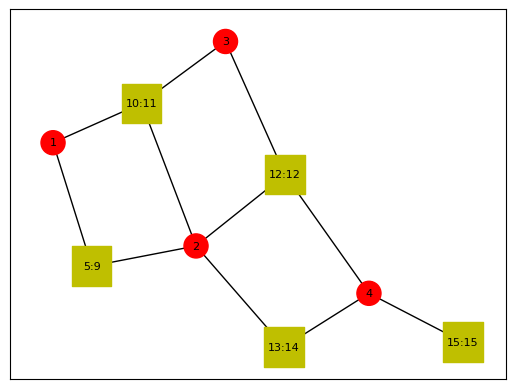

prune edges: [(1, 8), (5, 15), (6, 14), (11, 15)]
'/home/michael/gitrepos/bb-sbbu/data/nmr_rand/test34_chain_A_dmax_5.nmr'


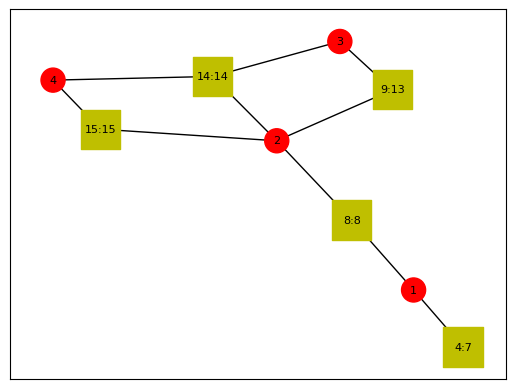

In [51]:
def plot_graph(G, fnmr, savefig=False):
    print("'" + fnmr + "'")
    pos = nx.spring_layout(G)    
    node_color = ['y' if ':' in node else 'r' for node in G.nodes()]
    node_size = [800 if ':' in node else 0 for node in G.nodes()]
    node_shape = ['o' if ':' in node else 's' for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, 
        node_size=node_size, 
        node_shape='s',
        node_color=node_color)    
    
    node_size = [0 if ':' in node else 300 for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, 
        node_size=node_size, 
        node_shape='o',
        node_color=node_color)
    
    nx.draw_networkx_labels(G, pos, font_color='k', font_size=8)
    nx.draw_networkx_edges(G, pos)
    if savefig:
        plt.savefig(fnmr.replace('.nmr', '.pdf'), format='pdf')
    plt.show()

# plot graphs
PDB = set(dfA['ID'])
for fn in sorted(os.listdir(nmr_folder)):
    if not fn.endswith('.nmr'):
        continue
    pdb = fn.split('_')[0]
    if pdb not in PDB:
        continue
    fn = os.path.join(nmr_folder, fn)
    fn = os.path.abspath(fn)
    nmr = NMR(fn)
    E, S = nmr.E, nmr.S # edges and segments
    G = nmr.ordering_graph # ordering graph
    print('prune edges:', [(e.i, e.j) for e in nmr.pruneEdges])
    plot_graph(G, fn, True)

## Results: data/nmr

In [52]:
nmr_folder = 'data/nmr/'

# run read_results.py and create results.csv
os.system('python read_results.py -wdir ' + nmr_folder)

df = pd.read_csv(os.path.join(nmr_folder, 'results.csv'))

# extract DMAX and PDB ID from fnmr
df['PDB'] = df['fnmr'].apply(lambda x: x.split('/')[-1].split('_')[0].replace('.nmr', ''))
df['DMAX'] = df['fnmr'].apply(lambda x: x.split('_')[-1].replace('.nmr',''))

print('tmax: ', df['tmax'].unique())
print('DMAX: ', df['DMAX'].unique())
print('timeoutBB: ', df['timeoutBB'].unique())

print('All columns:')
for col in sorted(df.columns):
    print('  ', col)

# columns to keep
cols = [
    'PDB', 'DMAX', 
    '|V|', '|E|', '|S|',
    'costRX', 'costGD', 'costSB', 'costBB', 
    'timeGD', 'timeSB', 'timeBB',  'timeoutBB',
]
df = df[cols]

# sort by DMAX and nnodes
df = df.sort_values(by=['DMAX', '|V|'])

df.head()

Parameters:
   wdir = data/nmr/

Getting log files from wdir=data/nmr/
Saving results to data/nmr/results.csv
tmax:  [7200]
DMAX:  ['7' '4' '5' '6']
timeoutBB:  [ 0. nan  1.]
All columns:
   DMAX
   PDB
   clean_log
   costBB
   costGD
   costRX
   costSB
   dump
   fnmr
   solver
   timeBB
   timeGD
   timeSB
   timeoutBB
   tmax
   verbose
   |E|
   |S|
   |V|


,PDB,DMAX,|V|,|E|,|S|,costRX,costGD,costSB,costBB,timeGD,timeSB,timeBB,timeoutBB
61,1n6t,4,30,16,14,44,44,44,44,0,0,0,0
36,1fw5,4,60,48,39,104,104,104,104,0,0,0,0
20,1adx,4,120,36,50,1342,1.08197e+06,2.16382e+06,1.08197e+06,0,0,7201,1
59,1bdo,4,240,56,97,2824,6.04032e+08,1e+09,6.04032e+08,0,0,7201,1
47,1all,4,480,284,269,864,1342,1342,1342,0,0,7201,1


In [91]:
# keep only DMAX in [5, 6]
df = df[df['DMAX'].isin(['5', '6'])]
df

for dmax in set(df['DMAX']):
    dfA = df[df['DMAX'] == dmax].copy()
    # drop DMAX column
    dfA.drop(columns=['DMAX'], inplace=True)
    # drop timeSB
    dfA.drop(columns=['timeSB'], inplace=True)
    # rename columns
    dfA.rename(inplace=True,
               columns={
                   'costRX': 'RX',
                   'costGD': 'Gap(GD)',
                   'costSB': 'Gap(SB)',
                   'costBB': 'Gap(BB)',
                   '|V|': '$|V|$',
                   '|E|': '$|E_p|$',
                   '|S|': '$|S_p|$',
               }, )
    # change to relative cost
    for col in ['Gap(GD)', 'Gap(SB)', 'Gap(BB)']:
        dfA[col] = dfA[col] / dfA['RX']
        dfA[col] = dfA[col] - 1
        # change to percentage string
        dfA[col] = dfA[col].apply(lambda x: '%.2f' % (x * 100))        
    # append ^* to BB col if timeout
    dfA['Gap(BB)'] = dfA.apply(lambda x: x['Gap(BB)'] +
                          '$^\dag$' if x['timeoutBB'] else x['Gap(BB)'], axis=1)
    # change to string
    dfA['RX'] = dfA['RX'].apply(lambda x: '%g' % x)
    # drop columns
    dfA.drop(columns=['timeGD', 'timeBB', 'timeoutBB'], inplace=True)
    # convert to latex
    tex = dfA.to_latex(index=False,
                       column_format='lcccccccc',
                       header=dfA.columns,  # list of column names
                       escape=False,
                       caption=f'Costs corresponding to DMAX={dmax}. The notation "$\dag$" denotes instances where the Branch-and-Bound (BB) algorithm exceeded the time limit.',
                       label=f'tab:cost_{dmax}',
                       multicolumn=False,
                       multicolumn_format='c')
    wdir = os.path.join('latex', nmr_folder)
    if not os.path.exists(wdir):
        os.mkdir(wdir)
    fn = os.path.join(wdir, f'cost_{dmax}.tex')
    fn = os.path.abspath(fn)
    print(f'Saving LaTeX table to "{fn}"')
    with open(fn, 'w') as fd:
        fd.write(tex)

    display(dfA)


Saving LaTeX table to "/home/michael/gitrepos/bb-sbbu/latex/data/nmr/cost_5.tex"


,PDB,$|V|$,$|E_p|$,$|S_p|$,RX,Gap(GD),Gap(SB),Gap(BB)
65,1n6t,30,92,27,54,0.00,0.00,0.00
16,1fw5,60,243,57,114,0.00,0.00,0.00
38,1adx,120,305,117,234,0.00,0.00,0.00
41,1bdo,240,625,237,474,0.00,0.00,0.00
42,1all,480,2009,477,954,0.00,0.00,0.00
14,6s61,516,2042,513,1026,0.00,0.00,0.00
24,1fhl,1002,3378,999,1998,0.00,0.00,0.00
44,4wua,1032,3402,1027,2060,0.00,0.00,0.00
19,6czf,1494,4747,1491,2982,0.00,0.00,0.00
3,5ijn,1950,6137,1941,3898,0.00,0.00,0.00


Saving LaTeX table to "/home/michael/gitrepos/bb-sbbu/latex/data/nmr/cost_6.tex"


,PDB,$|V|$,$|E_p|$,$|S_p|$,RX,Gap(GD),Gap(SB),Gap(BB)
35,1n6t,30,152,27,54,0.00,0.00,0.00
6,1fw5,60,384,57,114,0.00,0.00,0.00
64,1adx,120,654,117,234,0.00,0.00,0.00
48,1bdo,240,1437,237,474,0.00,0.00,0.00
56,1all,480,3498,477,954,0.00,0.00,0.00
46,6s61,516,3606,513,1026,0.00,0.00,0.00
28,1fhl,1002,6811,999,1998,0.00,0.00,0.00
32,4wua,1032,6612,1028,2058,0.00,0.00,0.00
31,6czf,1494,9687,1491,2982,0.00,0.00,0.00
43,5ijn,1950,12422,1944,3896,0.00,0.05,0.00
